In [1]:
import numpy as np
import networkx as nx
import powerlaw 
import netgraph
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
import pandas as pd
import os
import pickle

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler
#from Qommunity.samplers.regular.bayan_sampler import BayanSampler

from iterative_searcher.iterative_searcher import IterativeSearcher

from dendro import Dendrogram

aal3 = pd.read_csv("Brain-networks/AAL3v1.nii.txt", delimiter=" ", header=None) 
aal3_labels = {node:label for node,label in zip(aal3[2],aal3[1]) if node==node}
aal3_keys = {label:node for node,label in zip(aal3[2],aal3[1]) if node==node}
labels = {i:label for i, label in enumerate(aal3_labels.values())}
labels

{0: 'Precentral_L',
 1: 'Precentral_R',
 2: 'Frontal_Sup_2_L',
 3: 'Frontal_Sup_2_R',
 4: 'Frontal_Mid_2_L',
 5: 'Frontal_Mid_2_R',
 6: 'Frontal_Inf_Oper_L',
 7: 'Frontal_Inf_Oper_R',
 8: 'Frontal_Inf_Tri_L',
 9: 'Frontal_Inf_Tri_R',
 10: 'Frontal_Inf_Orb_2_L',
 11: 'Frontal_Inf_Orb_2_R',
 12: 'Rolandic_Oper_L',
 13: 'Rolandic_Oper_R',
 14: 'Supp_Motor_Area_L',
 15: 'Supp_Motor_Area_R',
 16: 'Olfactory_L',
 17: 'Olfactory_R',
 18: 'Frontal_Sup_Medial_L',
 19: 'Frontal_Sup_Medial_R',
 20: 'Frontal_Med_Orb_L',
 21: 'Frontal_Med_Orb_R',
 22: 'Rectus_L',
 23: 'Rectus_R',
 24: 'OFCmed_L',
 25: 'OFCmed_R',
 26: 'OFCant_L',
 27: 'OFCant_R',
 28: 'OFCpost_L',
 29: 'OFCpost_R',
 30: 'OFClat_L',
 31: 'OFClat_R',
 32: 'Insula_L',
 33: 'Insula_R',
 34: 'Cingulate_Mid_L',
 35: 'Cingulate_Mid_R',
 36: 'Cingulate_Post_L',
 37: 'Cingulate_Post_R',
 38: 'Hippocampus_L',
 39: 'Hippocampus_R',
 40: 'ParaHippocampal_L',
 41: 'ParaHippocampal_R',
 42: 'Amygdala_L',
 43: 'Amygdala_R',
 44: 'Calcarine_L',
 4

In [2]:
class GraphFromCSV:
    """
    It creates an object with different properties from a csv. Everything related to it, will be
        saved with the provided 'name' followed by the proper extensions.
    As of now, this is not the latest version of this class (or python script), but for this pipeline is enough.
    """

    def __init__(self, graph, name, base_dir='/'):
        self.graph = graph  # Graph file name
        self.conns = pd.read_csv(graph, delimiter=',', header=None).values # Graph connections
        self.graph_size = self.conns.shape
            
        self.name = name
        if base_dir == '/':
            self.dir = os.getcwd()+'/'
        else:
            self.dir = base_dir
        self.originals = self.conns
        # TODO: Add check path for base_dir!

    def __revert(self):
        """
        Reorders AAL3 regions by hemispheres.
        Odd indices correspond to Left hemisphere regions.
        Even indices correspond to rigth hemisphere regions.
        Stores a dictionary with the reodering of indices.
        """
        odd_odd = self.conns[::2, ::2]
        odd_even = self.conns[::2, 1::2]
        first = np.vstack((odd_odd, odd_even))
        even_odd = self.conns[1::2, ::2]
        even_even= self.conns[1::2, 1::2]
        second = np.vstack((even_odd, even_even))
        self.conns = np.hstack((first,second))

        # To map actual labels with original ones
        labels = np.array([x for x in range(0, self.graph_size[0])])
        left = np.array([x for x in range(1, self.graph_size[0], 2)])
        rigth = np.array([x for x in range(0, self.graph_size[0], 2)])
        self.hemis = dict(zip(labels, np.concatenate((left, rigth), axis=0)))

    def __take_log(self):
        """
        Takes the natural logarithm of the connections. Enhances visualisation of the matrix.
        """
        self.conns = np.log1p(self.conns)

    def __plot_graph(self, save=True, show=False, fig_size=(20,15), dpi=500):
        """
        Plot a graph. It assumes that the adjancency matrix is a csv file.
        """
        plt.figure(figsize=fig_size)
        plt.imshow(self.conns)
        cbar = plt.colorbar()
        cbar.set_label('Connection Strength', rotation=270)
        plt.tight_layout()
        if save:
            plt.savefig(self.dir+self.name+'.svg', format='svg', dpi=dpi)      
        if show:
            plt.show()     

    def process_graph(self, log=True, reshuffle=True, save=True, show=False, fig_size=(20,15)):
        """
        Applies default operations to the graph to work with it.
        """
        self.processed = True # The object has been processed
        if self.conns.shape[0] <= 1:
            raise ValueError("You are trying to process a flat graph. Can't do it. Unflatten your graph and set it to default.")
        else:
            if log:
                self.__take_log()
            if reshuffle:
                self.__revert()
            self.__plot_graph(save=save, show=show, fig_size=(20,15))
    
    def get_connections(self, ini=False):
        if not ini:
            return self.conns 
        else:
            return self.originals
    
    def flatten_graph(self, save=True):
        """
        Flatten the lower triangular adjancency matrix of the graph. 
        The flattened graph becomes available after applying this method.
        """
        x = self.conns.shape[0] # Dimensions of the graph 
        if x <= 1:
            raise ValueError("Dimension of the graph is 1 (or lower). You can't flattened an already flattened graph")
        else:
            dims = int(self.conns.shape[0]*(self.conns.shape[0]-1)/2)
            self.flat_conns = np.zeros((1,dims))
            k = 0
            for i in range(x):
                for j in range(i):
                    self.flat_conns[0,k] = self.conns[i,j]
                    k += 1
            if save:
                np.savetxt(self.dir+self.name+'_flatCM.csv', self.flat_conns, delimiter=',')
            return self.flat_conns

    def unflatten_graph(self, to_default=False):
        """
        Unflatten a graph and transform it to a square symmetric matrix. 
        The unflattened graph becomes available after applying this method.
        to_default: bool - The unflattened matrix becomes the default graph and replaces 
            the initial flat graph. As a checkpoint, the flattened graph is saved in the directory(default: False)
        """
        x = self.conns.shape[0] # First dimension of the flattened graph 
        flat_dim = self.conns.shape[1]
        if x > 1:
            raise ValueError("Dimension of the graph greater than 1. You can't unflattened an already unflattened graph")
        else:
            dims = int(1+np.sqrt(1+8*flat_dim)/2) # Dimensions of the squared graph
            self.unflat_conns = np.zeros((dims,dims))
            k = 0
            for i in range(dims):
                for j in range(i):
                    self.unflat_conns[i, j] = self.conns[0, k]
                    self.unflat_conns[j, i] = self.conns[0, k]
                    k += 1
            if to_default:
                # We save the flat graph with another name
                np.savetxt(self.dir+self.name+'_flatCM.csv', self.conns, delimiter=',')
                # We replace the original file with the unflattend graph
                np.savetxt(self.graph, self.unflat_conns, delimiter=',')
                # We re-initialize the graph with the unflattened graph and both the same name and directory
                self.__init__(self.graph, self.name, self.dir)
            return self.unflat_conns

In [44]:
G_process = GraphFromCSV("Brain-networks/control/ses-preop/sub-CON10_ses-preop_flatCM.csv", name="sub-CON10_ses-preop", base_dir="Brain-networks/")
network = G_process.unflatten_graph(to_default=False)
network = np.delete(network, [34,35,80,81], axis=0)
network = np.delete(network, [34,35,80,81], axis=1)
#network = network/network.max()
#network = np.where(network>=0.1, 1, 0)
graph = nx.from_numpy_array(network, create_using=nx.Graph, edge_attr="weight")
name = "Brain-networks/adv-brain_network-runs_20__weighted__no-threshold.npy"

num_runs = 20
resolution = 1

cs_Louv, ms_Louv, _ = IterativeSearcher(LouvainSampler(graph, resolution=resolution)).run(num_runs=num_runs, save_results=False)
print("Louvain modularity:", ms_Louv.max())
cs_Leid, ms_Leid, _ = IterativeSearcher(LeidenSampler(graph, resolution=resolution)).run(num_runs=num_runs, save_results=False)
print("Leiden modularity:", ms_Leid.max())

100%|██████████| 20/20 [00:00<00:00, 23.24it/s]


Louvain modularity: 0.6108117734724825


100%|██████████| 20/20 [00:00<00:00, 34.40it/s]

Leiden modularity: 0.6112827841745766


In [4]:
try:
    results_adv = np.load(name, allow_pickle=True)
except:
    adv_searcher = IterativeSearcher(AdvantageSampler(graph, resolution=resolution, num_reads=100, use_clique_embedding=True))
    results_adv = adv_searcher.run_with_sampleset_info(num_runs=num_runs, save_results=False)
    np.save(name, results_adv, allow_pickle=True)

mods_Adv = results_adv.modularity
mod_Adv = mods_Adv.max()
communities, division_tree, division_modularities = results_adv.communities[mods_Adv.argmax()], results_adv.division_tree[mods_Adv.argmax()], results_adv.division_modularities[mods_Adv.argmax()]
print("H. annealing modularity:", mod_Adv)

H. annealing modularity: 0.599833508855978


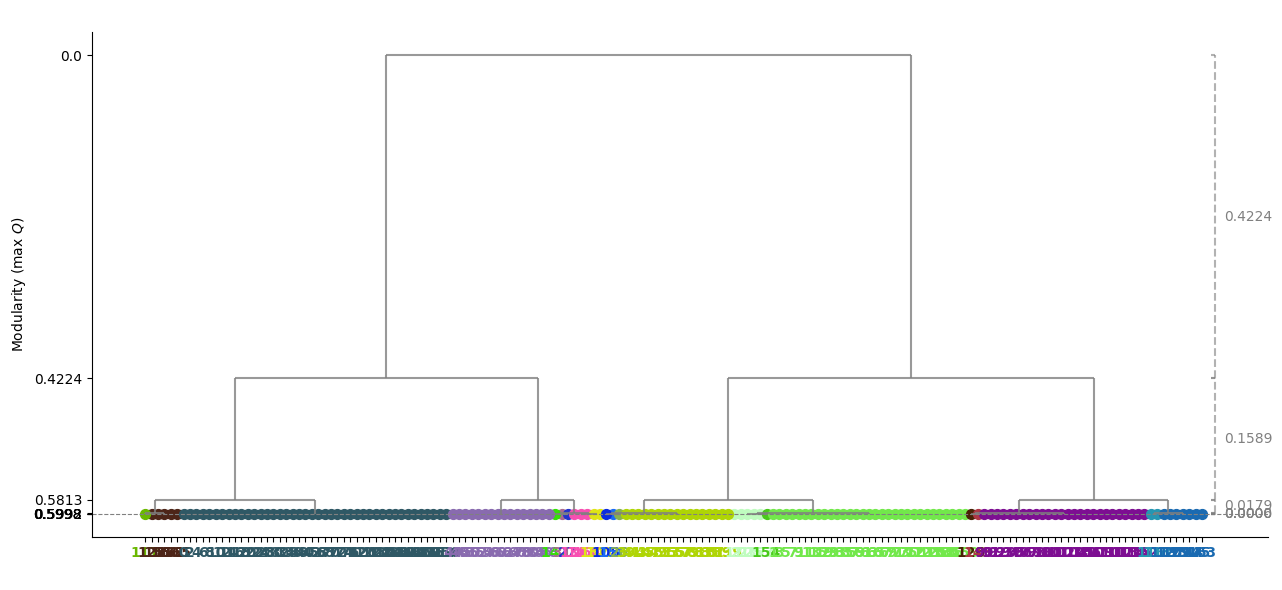

In [5]:
dendro = Dendrogram(graph, communities, division_modularities, division_tree)
fig, ax = plt.subplots(1,1,figsize=(13,6))
community_labels = [f"Group {i+1}" for i in range(len(communities))]
dendro.draw(
    display_leafs=True,
    yaxis_abs_log=False,
    ax=ax,
    fig=fig,
    communities_labels=community_labels,
    color_seed=1,
    #fig_saving_path="./Power-law/dendrogram.svg",
    #title='Hierarchicies inside a clustered power-law network'
)

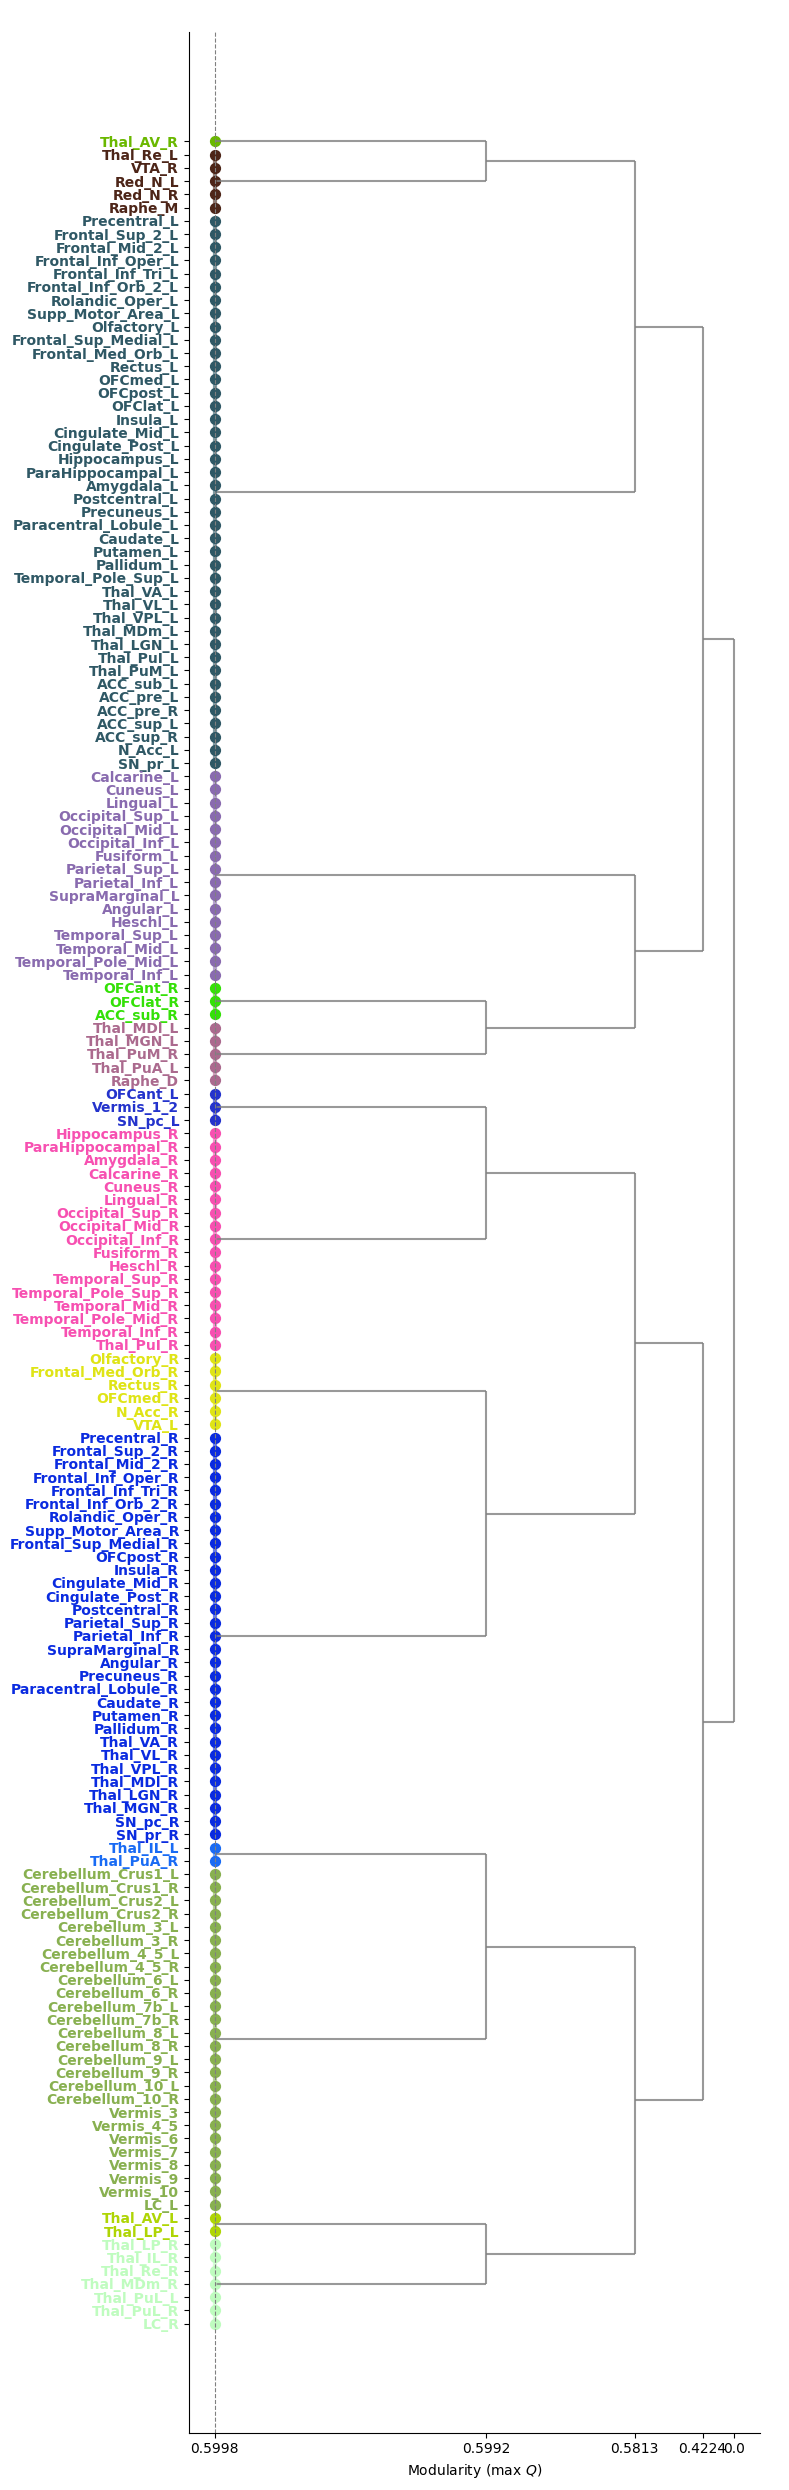

In [55]:
dendro = Dendrogram(graph, division_tree[-3], division_modularities[:-2], division_tree[:-2])
fig, ax = plt.subplots(1,1,figsize=(8,25))
community_labels = [f"Group {i+1}" for i in range(len(communities))]
dendro.draw_horizontal(
    display_leafs=False,
    yaxis_abs_log=True,
    ax=ax,
    fig=fig,
    communities_labels=community_labels,
    node_labels_mapping=labels,
    xlabel_rotation=45,
    color_seed=1,
    fig_saving_path="./Brain-networks/dendrogram_adv.svg",
    #title='Hierarchicies inside a clustered power-law network'
)

In [28]:
import nibabel as nib
from matplotlib.colors import ListedColormap
import nilearn.plotting as plotting
Nslices = 20
alpha = .7

AAL3_IMG = nib.load("Brain-networks/AAL3v1.nii.gz")
MNI = nib.load("Brain-networks/MNI152_T1_1mm.nii.gz")

In [51]:
# EARLY DIVISION
# FINAL DIVISION
grouped_img = AAL3_IMG.get_fdata()*0
for i,c in enumerate(division_tree[-2]):
    comm = AAL3_IMG.get_fdata()*0
    for roi in c:
        comm += np.where(AAL3_IMG.get_fdata()==int(aal3_keys[labels[roi]]), i+1, 0)
    grouped_img += comm
GROUPED = nib.Nifti1Image(grouped_img, AAL3_IMG.affine, AAL3_IMG.header)
nib.save(GROUPED, f"Brain-networks/ADV_grouped_AAL3.nii.gz")

# Define 14 distinct colors
colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FFA500", "#A52A2A"
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors, name="custom_14color_cmap")

fig, ax = plt.subplots(3, 1, figsize=(40, 10), facecolor="k")
fig.subplots_adjust(hspace=0, left=0, right=1, top=1, bottom=0)

display_x = plotting.plot_anat(
    MNI, 
    axes=ax[0], 
    display_mode="x", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_x.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_y = plotting.plot_anat(
    MNI, 
    axes=ax[1], 
    display_mode="y", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_y.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_z = plotting.plot_anat(
    MNI, 
    axes=ax[2], 
    display_mode="z", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_z.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

fig.suptitle("H. annealing early Structural division", fontweight='bold', color='white', fontsize=20)
fig.savefig(f"Brain-networks/ADV_plot_early.pdf", format='pdf', dpi=100)
plt.close()

In [53]:
# FINAL DIVISION
grouped_img = AAL3_IMG.get_fdata()*0
for i,c in enumerate(division_tree[-3]):
    comm = AAL3_IMG.get_fdata()*0
    for roi in c:
        comm += np.where(AAL3_IMG.get_fdata()==int(aal3_keys[labels[roi]]), i+1, 0)
    grouped_img += comm
GROUPED = nib.Nifti1Image(grouped_img, AAL3_IMG.affine, AAL3_IMG.header)
nib.save(GROUPED, f"Brain-networks/ADV_grouped_AAL3.nii.gz")

# Define 14 distinct colors
colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FFA500", "#A52A2A"
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors, name="custom_14color_cmap")

fig, ax = plt.subplots(3, 1, figsize=(40, 10), facecolor="k")
fig.subplots_adjust(hspace=0, left=0, right=1, top=1, bottom=0)

display_x = plotting.plot_anat(
    MNI, 
    axes=ax[0], 
    display_mode="x", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_x.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_y = plotting.plot_anat(
    MNI, 
    axes=ax[1], 
    display_mode="y", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_y.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_z = plotting.plot_anat(
    MNI, 
    axes=ax[2], 
    display_mode="z", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_z.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

fig.suptitle("H. annealing final Structural division", fontweight='bold', color='white', fontsize=20)
fig.savefig(f"Brain-networks/ADV_plot_final.pdf", format='pdf', dpi=100)
plt.close()

In [49]:
## We plot the Louvain results
grouped_img = AAL3_IMG.get_fdata()*0
for i,c in enumerate(cs_Louv[ms_Louv.argmax()]):
    comm = AAL3_IMG.get_fdata()*0
    for roi in c:
        comm += np.where(AAL3_IMG.get_fdata()==int(aal3_keys[labels[roi]]), i+1, 0)
    grouped_img += comm
GROUPED = nib.Nifti1Image(grouped_img, AAL3_IMG.affine, AAL3_IMG.header)
nib.save(GROUPED, f"Brain-networks/LOUV_grouped_AAL3.nii.gz")

fig, ax = plt.subplots(3, 1, figsize=(40, 10), facecolor="k")
fig.subplots_adjust(hspace=0, left=0, right=1, top=1, bottom=0)

display_x = plotting.plot_anat(
    MNI, 
    axes=ax[0], 
    display_mode="x", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_x.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_y = plotting.plot_anat(
    MNI, 
    axes=ax[1], 
    display_mode="y", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_y.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_z = plotting.plot_anat(
    MNI, 
    axes=ax[2], 
    display_mode="z", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_z.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

fig.suptitle("Louvain Structural division", fontweight='bold', color='white', fontsize=20)
fig.savefig(f"Brain-networks/LOUV_plot.pdf", format='pdf', dpi=100)
plt.close()

In [48]:
# We plot the Leiden results
## We plot the Louvain results
grouped_img = AAL3_IMG.get_fdata()*0
for i,c in enumerate(cs_Leid[ms_Leid.argmax()]):
    comm = AAL3_IMG.get_fdata()*0
    for roi in c:
        comm += np.where(AAL3_IMG.get_fdata()==int(aal3_keys[labels[roi]]), i+1, 0)
    grouped_img += comm
GROUPED = nib.Nifti1Image(grouped_img, AAL3_IMG.affine, AAL3_IMG.header)
nib.save(GROUPED, f"Brain-networks/LEID_grouped_AAL3.nii.gz")

fig, ax = plt.subplots(3, 1, figsize=(40, 10), facecolor="k")
fig.subplots_adjust(hspace=0, left=0, right=1, top=1, bottom=0)

display_x = plotting.plot_anat(
    MNI, 
    axes=ax[0], 
    display_mode="x", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_x.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_y = plotting.plot_anat(
    MNI, 
    axes=ax[1], 
    display_mode="y", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_y.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

display_z = plotting.plot_anat(
    MNI, 
    axes=ax[2], 
    display_mode="z", 
    cut_coords=np.linspace(-80,80,Nslices), 
    draw_cross=False, 
    black_bg=True,
    annotate=False
)
display_z.add_overlay(
    GROUPED,
    cmap = custom_cmap,
    alpha=alpha
)

fig.suptitle("Leiden Structural division", fontweight='bold', color='white', fontsize=20)
fig.savefig(f"Brain-networks/LEID_plot.pdf", format='pdf', dpi=100)
plt.close()